In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Specify the path to your zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Datasets/ShellAiData.zip' # Replace with the actual path to your zip file

# Specify the directory where you want to extract the contents
extracted_path = '/content' # Replace with your desired extraction path

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f'Dataset extracted to {extracted_path}')

Dataset extracted to /content


In [ ]:
!pip install shap
!pip install pysr

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor, callback
from sklearn.cross_decomposition import PLSRegression

import shap
from pysr import PySRRegressor
import joblib


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
!pip install --upgrade xgboost

In [ ]:
import pandas as pd
fuelData = pd.read_csv('/content/dataset/train.csv')

target = [cols for cols in fuelData.columns if "Blend" in cols]
X = fuelData.drop(columns=target)
y = fuelData[target]

Tune n_estimators with early stopping

In [ ]:
print("Tuning n_estimators using early stopping per target...")
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X, y, test_size=0.2, random_state=42)

import xgboost as xgb  # native booster API

best_iterations = []

for col in target:
    print(f"Tuning for {col}...")

    dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub[col])
    dval = xgb.DMatrix(X_val_sub, label=y_val_sub[col])

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': 6,
    }

    watchlist = [(dtrain, 'train'), (dval, 'eval')]

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=watchlist,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    best_iterations.append(booster.best_iteration)
    print(f"✅ {col} best_iteration: {booster.best_iteration}")

optimal_n = int(np.mean(best_iterations))
print(f"\n Optimal n_estimators across outputs: {optimal_n}")

Tuning n_estimators using early stopping per target...
Tuning for BlendProperty1...
✅ BlendProperty1 best_iteration: 476
Tuning for BlendProperty2...
✅ BlendProperty2 best_iteration: 422
Tuning for BlendProperty3...
✅ BlendProperty3 best_iteration: 331
Tuning for BlendProperty4...
✅ BlendProperty4 best_iteration: 592
Tuning for BlendProperty5...
✅ BlendProperty5 best_iteration: 252
Tuning for BlendProperty6...
✅ BlendProperty6 best_iteration: 551
Tuning for BlendProperty7...
✅ BlendProperty7 best_iteration: 276
Tuning for BlendProperty8...
✅ BlendProperty8 best_iteration: 678
Tuning for BlendProperty9...
✅ BlendProperty9 best_iteration: 467
Tuning for BlendProperty10...
✅ BlendProperty10 best_iteration: 728

 Optimal n_estimators across outputs: 477


Retrain on full data

In [ ]:
print("Retraining MultiOutputRegressor with optimal n_estimators on full dataset...")
final_model = MultiOutputRegressor(XGBRegressor(n_estimators=optimal_n, learning_rate=0.05, max_depth=6, random_state=42))
final_model.fit(X, y)

Retraining MultiOutputRegressor with optimal n_estimators on full dataset...


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=477, n_jobs=None,
                                            num_parallel_tree=None, ...))

save the model

In [ ]:
joblib.dump(final_model, '/content/multioutput_xgb_model.pkl')
print(" Model saved to: /content/multioutput_xgb_model.pkl")

 Model saved to: /content/multioutput_xgb_model.pkl


# SHAP explainability for first target estimator

💡 SHAP for BlendProperty1
✅ Saved shap_BlendProperty1.png
💡 SHAP for BlendProperty2
✅ Saved shap_BlendProperty2.png
💡 SHAP for BlendProperty3
✅ Saved shap_BlendProperty3.png
💡 SHAP for BlendProperty4
✅ Saved shap_BlendProperty4.png
💡 SHAP for BlendProperty5
✅ Saved shap_BlendProperty5.png
💡 SHAP for BlendProperty6
✅ Saved shap_BlendProperty6.png
💡 SHAP for BlendProperty7
✅ Saved shap_BlendProperty7.png
💡 SHAP for BlendProperty8
✅ Saved shap_BlendProperty8.png
💡 SHAP for BlendProperty9
✅ Saved shap_BlendProperty9.png
💡 SHAP for BlendProperty10
✅ Saved shap_BlendProperty10.png


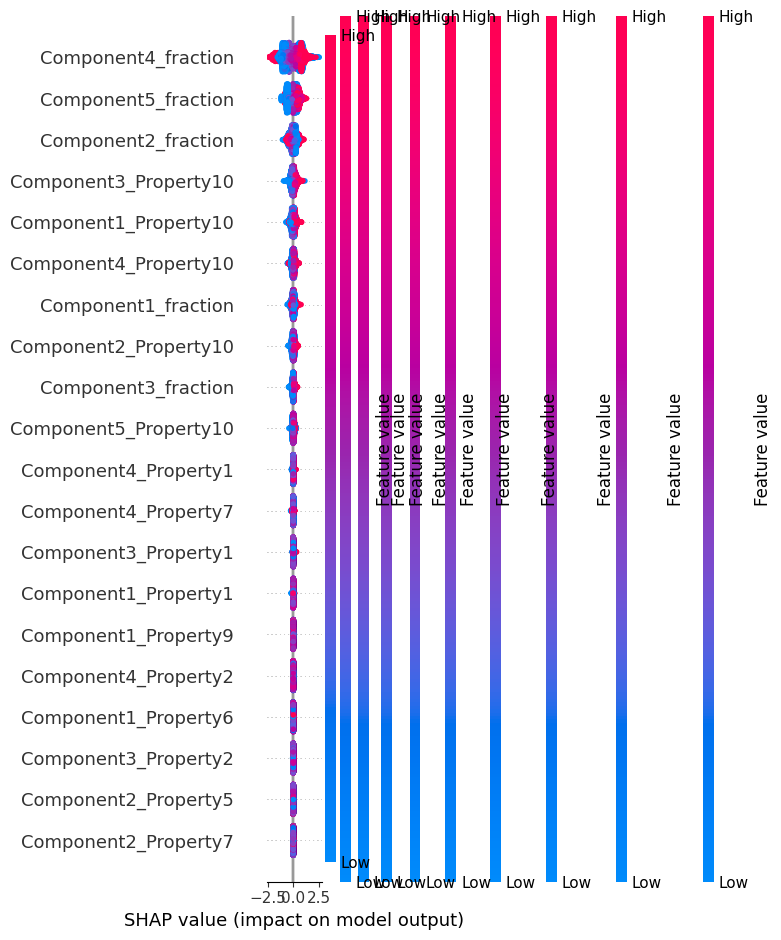

In [ ]:
for i, target_name in enumerate(y.columns):
    print(f"💡 SHAP for {target_name}")
    explainer = shap.Explainer(final_model.estimators_[i])
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, show=False)
    plt.savefig(f"/content/shap_{target_name}.png")
    print(f"✅ Saved shap_{target_name}.png")


# Correlation matrix (True vs Predicted)

Generating correlation plots...
✅ Correlation matrix saved.


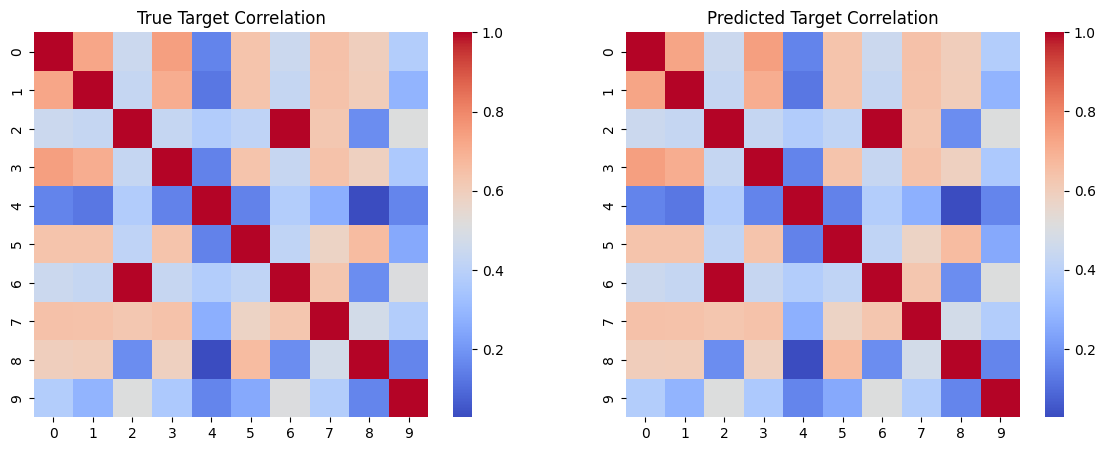

In [ ]:
print("Generating correlation plots...")
y_pred = final_model.predict(X)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.heatmap(np.corrcoef(y.T), cmap='coolwarm')
plt.title('True Target Correlation')

plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(y_pred.T), cmap='coolwarm')
plt.title('Predicted Target Correlation')

plt.savefig("/content/correlation_matrix.png")
print("✅ Correlation matrix saved.")

# PLS Regression

In [ ]:
print("Running PLS Regression for latent analysis...")
pls = PLSRegression(n_components=5)
pls.fit(X, y)
print('PLS X weights shape:', pls.x_weights_.shape)
print('PLS Y weights shape:', pls.y_weights_.shape)

Running PLS Regression for latent analysis...
PLS X weights shape: (55, 5)
PLS Y weights shape: (10, 5)


# Symbolic Regression on first target

In [ ]:
print("Running Symbolic Regression on first target column...")
symbolic_model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["log", "exp", "sqrt"],
    model_selection="best",
)
symbolic_model.fit(X, y.iloc[:, 0])
print(symbolic_model)

Running Symbolic Regression on first target column...


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
